# Pull all data and fit on it - classify artists

## TODOs
- sanity check all my codes
- add in actual test data instead of using just train/val
- artists but use entire dataset, not a balanced version
- copy of this, but for style instead
- 

In [59]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as T

import numpy as np
import timeit

dtype = torch.FloatTensor
ytype = torch.LongTensor
if (torch.cuda.is_available()):
   dtype = torch.cuda.FloatTensor
   ytype = torch.cuda.LongTensor
print(ytype)
print(dtype)
print_every = 20

    
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image
    
def reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()

def train(model, loss_fn, optimizer, loader_train, loader_val, num_epochs = 1):
    # train_loss_hist = []
    train_acc_hist = []
    # val_loss_hist = []
    val_acc_hist = []
    for epoch in range(num_epochs):
        print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
        model.train()
        for t, (x, y) in enumerate(loader_train):
            x_var = Variable(x.type(dtype))
            y_var = Variable(y.type(dtype).long())
            scores = model(x_var)
            loss = loss_fn(scores, y_var)
            if (t + 1) % print_every == 0:
                print('t = %d, loss = %.4f' % (t + 1, loss.data[0]))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # record training and validation accuracy at the end of each epoch
        train_acc_hist.append(check_accuracy(model, loader_train))
        val_acc_hist.append(check_accuracy(model, loader_val))
        
    return [train_acc_hist, val_acc_hist]
    
def check_accuracy(model, loader):
    print('Checking accuracy!')
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    for x, y in loader:
        y = y.view(-1, 1).type(ytype)
        x_var = Variable(x.type(dtype), volatile=True)
        scores = model(x_var)
        _, preds = scores.data.cpu().max(1)
        
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return 100*acc

<class 'torch.LongTensor'>
<class 'torch.FloatTensor'>


# Prep the data

In [43]:
## ALL MAIN ARGUMENTS FOR THE SCRIPT ##

dat_folder = '../data/'
img_folder = '../data/train_1/'

filter_subset = True # True if we want to filter to just train _1

## THIS VERSION OF SCRIPT HAS EQUAL NUMBER OF PAINTINGS PER ARTIST
num_train = 40
num_val = 10
num_samples = num_train + num_val # threshold to include an artist
b_size = 4 # batch size for the data loaders


In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image, ImageFilter
import random
import cv2
import os, glob

t = pd.read_csv(dat_folder + 'all_data_info.csv')

# filter down (if needed)
if (filter_subset):
    t = t[t['new_filename'].str.startswith('1')]
    t = t[t['in_train']]

t.head()
# print(t.shape)

,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
0,Barnett Newman,1955.0,abstract,15530.0,6911.0,9201912.0,wikiart,Color Field Painting,Uriel,train_only,True,102257.jpg
23,Jan van Eyck,1439,religious painting,4000.0,8311.0,28783029.0,wikiart,Northern Renaissance,The Madonna in the Church,train_and_test,True,16876.jpg
42,Thomas Gainsborough,1783,landscape,5712.0,4704.0,11791905.0,wikiart,Rococo,The Mall in St. James's Park,train_and_test,True,1164.jpg
46,Lyonel Feininger,1926.0,cityscape,4472.0,5894.0,7382419.0,wikiart,Cubism,Gelmeroda IX,train_only,True,19385.jpg
74,Henri de Toulouse-Lautrec,1895,genre painting,5833.0,3985.0,3389831.0,wikiart,Post-Impressionism,Abandonment (The pair),train_and_test,True,17354.jpg


In [45]:
# t['artist'].value_counts()

In [46]:
# list of all artists to include
temp = t['artist'].value_counts()
artists = temp[temp >= num_samples].index.tolist()
num_artists = len(artists)

print(str(len(artists)) + ' artists being classified')

# pull train and val data for just those artists
train_dfs = []
val_dfs = []

for a in artists:
    df = t[t['artist'].str.startswith(a, na=False)].sample(n=num_samples)
    t_df = df.sample(n=num_train)
    v_df = df.loc[~df.index.isin(t_df.index)]
    
    train_dfs.append(t_df)
    val_dfs.append(v_df)

train_df = pd.concat(train_dfs)
val_df = pd.concat(val_dfs)

# modify data to have numbers for artists and style, and create appropriate mappings
unique_artists = train_df['artist'].str.upper().unique()
unique_styles = train_df['style'].str.upper().unique()

artist_l = {val: idx for (idx, val) in enumerate(unique_artists)}
# style_l = {val: idx for (idx, val) in enumerate(unique_styles)}

artist_labels = {idx: val for (idx, val) in enumerate(unique_artists)}
# style_labels = {idx: val for (idx, val) in enumerate(unique_styles)}

train_df['artist_label'] = np.array([artist_l[a] for a in train_df['artist'].str.upper().values])
# train_df['style_label'] = np.array([style_l[a] for a in train_df['style'].str.upper().values])

val_df['artist_label'] = np.array([artist_l[a] for a in val_df['artist'].str.upper().values])
# val_df['style_label'] = np.array([style_l[a] for a in val_df['style'].str.upper().values])

print("Done")

24 artists being classified
Done


In [50]:
# Display a few images by the artists

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image, ImageFilter
import random
import cv2
import os, glob

if len(artists) <= 4: # so we don't print this if it's too large
    i_ = 1
    plt.rcParams['figure.figsize'] = (10.0, 10.0)
    plt.subplots_adjust(wspace=0, hspace=0)
    for a in artists:
        print(a)
        artist_df = t[t['artist'].str.startswith(a)]
        imgs = []
        for file in artist_df['new_filename']:
            imgs.append(cv2.resize(cv2.imread(img_folder + file), (50,50)))
        for img in imgs[10:20]:
            plt.subplot(len(artists), 10, i_)
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.axis('off')
            i_ += 1

In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.utils.data import TensorDataset

import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as T

train_tensors = []
val_tensors = []

# load in imags with cv2, then convert to matrices that work with pytorch
train_transform = T.Compose([
        T.ToPILImage(),
        T.RandomSizedCrop(224),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
val_transform = T.Compose([
        T.ToPILImage(),
        T.Scale(256),
        T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

for i in train_df['new_filename']:
    # print('../data/train_1/' + i)
    img = cv2.imread(img_folder + i)
    
    # transforms and make a Tensor
    img_tensor = train_transform(img)
    train_tensors.append(img_tensor)

for i in val_df['new_filename']:
    img = cv2.imread(img_folder + i)
    
    # transforms and make a Tensor
    img_tensor = val_transform(img)
    val_tensors.append(img_tensor)
    
train_tensors = torch.stack(train_tensors)
val_tensors = torch.stack(val_tensors)

# create DataLoaders
train_labels = torch.Tensor(train_df['artist_label'].values.astype(np.float32))
val_labels = torch.Tensor(val_df['artist_label'].values.astype(np.float32))

train_dset = TensorDataset(train_tensors, train_labels)
loader_train = DataLoader(train_dset, batch_size=b_size, shuffle=True)
    
val_dset = TensorDataset(val_tensors, val_labels)
loader_val = DataLoader(val_dset, batch_size=b_size, shuffle=True)

print("Done")

Done


In [56]:
# Create a simple network to use as a baseline

simple_model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1), # -> 112
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(32),
    nn.MaxPool2d(2), # -> 56
    nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1), # -> 28
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(32),
    nn.MaxPool2d(2), # -> 14
    Flatten(),
    nn.Linear(6272, 200),
    nn.ReLU(inplace=True),
    nn.Linear(200, num_artists),
)

simple_model.type(dtype)
loss_fn = nn.CrossEntropyLoss().type(dtype)
optimizer = optim.Adam(simple_model.parameters(), lr=1e-2)
optimizer2 = optim.Adam(simple_model.parameters(), lr=1e-3)

In [57]:
# Now we're going to feed a random batch into the model and make sure the output is the right size
x = torch.randn(64, 3, 224, 224).type(dtype)
x_var = Variable(x.type(dtype)) # Construct a PyTorch Variable out of your input data
ans = simple_model(x_var)        # Feed it through the model! 

# Check to make sure what comes out of your model
# is the right dimensionality... this should be True
# if you've done everything correctly
np.array_equal(np.array(ans.size()), np.array([64, num_artists]))

True

In [62]:
# apply my simple network to the dataset
# reset(simple_model)
# train(simple_model, loss_fn, optimizer, loader_train, num_epochs = 5)
train_acc_hist, val_acc_hist = train(simple_model, loss_fn, optimizer2, loader_train, loader_val, num_epochs = 5)


Starting epoch 1 / 5
t = 20, loss = 1.7483
t = 40, loss = 2.2504
t = 60, loss = 2.0650
t = 80, loss = 1.0502
t = 100, loss = 2.4221
t = 120, loss = 2.2931
t = 140, loss = 2.6001
t = 160, loss = 1.7515
t = 180, loss = 1.0984
t = 200, loss = 1.3086
t = 220, loss = 2.0498
t = 240, loss = 1.5552
Checking accuracy!
Got 611 / 960 correct (63.65)
Checking accuracy!
Got 60 / 240 correct (25.00)
Starting epoch 2 / 5
t = 20, loss = 0.9241
t = 40, loss = 0.5869
t = 60, loss = 1.0100
t = 80, loss = 0.5668
t = 100, loss = 0.8845
t = 120, loss = 0.5611
t = 140, loss = 0.3163
t = 160, loss = 0.8038
t = 180, loss = 0.3788
t = 200, loss = 0.2924
t = 220, loss = 0.6164
t = 240, loss = 0.6700
Checking accuracy!
Got 888 / 960 correct (92.50)
Checking accuracy!
Got 58 / 240 correct (24.17)
Starting epoch 3 / 5
t = 20, loss = 0.1022
t = 40, loss = 0.1384
t = 60, loss = 0.0971
t = 80, loss = 0.5383
t = 100, loss = 0.2298
t = 120, loss = 0.0283
t = 140, loss = 0.0188
t = 160, loss = 0.0282
t = 180, loss = 0.5

# Training accuracy over time chart - showing the overfit


[63.645833333333336, 92.5, 96.97916666666667, 97.70833333333333, 98.95833333333334]
[25.0, 24.166666666666668, 22.916666666666664, 22.5, 22.916666666666664]
[1 2 3 4 5]


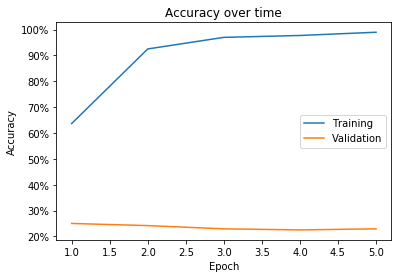

In [72]:
epochs = np.arange(len(train_acc_hist)) + 1
print(train_acc_hist)
print(val_acc_hist)
print(epochs)

# Plot the points using matplotlib
plt.plot(epochs, train_acc_hist)
plt.plot(epochs, val_acc_hist)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over training')
plt.legend(['Training', 'Validation'])

# y ticks
vals = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in vals])

plt.show()


In [ ]:
# transfer learning on top of ResNet18

